# ComfyUI Workflow Helper

This notebook helps you run a ComfyUI workflow by modifying specific parameters, sending the request to your local ComfyUI server, and **displaying the results**.

In [ ]:
import json
import random
import urllib.request
import urllib.parse
import os
import time
from IPython.display import display, Image

# Server Address
COMFYUI_SERVER_ADDRESS = "127.0.0.1:8188"
WORKFLOW_FILE = "my_test_workflow.json"

def queue_prompt(prompt_workflow):
    p = {"prompt": prompt_workflow}
    data = json.dumps(p).encode('utf-8')
    url = "http://{}/prompt".format(COMFYUI_SERVER_ADDRESS)
    req = urllib.request.Request(url, data=data)
    return json.loads(urllib.request.urlopen(req).read())

def get_history(prompt_id):
    url = "http://{}/history/{}".format(COMFYUI_SERVER_ADDRESS, prompt_id)
    with urllib.request.urlopen(url) as response:
        return json.loads(response.read())

def get_image(filename, subfolder, folder_type):
    data = {"filename": filename, "subfolder": subfolder, "type": folder_type}
    url_values = urllib.parse.urlencode(data) #CGI get 傳參數方法?
    url = "http://{}/view?{}".format(COMFYUI_SERVER_ADDRESS, url_values)
    with urllib.request.urlopen(url) as response:
        return response.read()

In [14]:
# Load the workflow
with open(WORKFLOW_FILE, 'r') as f:
    workflow = json.load(f)

print(f"Loaded workflow with {len(workflow)} nodes.")

Loaded workflow with 7 nodes.


## User Configuration

Modify the variables below to customize your image generation.

In [15]:
# --- CONFIGURATION START ---
user_prompt = "A futuristic city with flying cars, cyberpunk style, neon lights"
user_width = 32
user_height = 32
output_filename = "my_comfyui_output"
# --- CONFIGURATION END ---

In [16]:
# Modify the workflow

# 1. Set the Prompt (Node 6)
if "6" in workflow:
    workflow["6"]["inputs"]["text"] = user_prompt
else:
    print("Warning: Node 6 (CLIPTextEncode) not found!")

# 2. Set Resolution (Node 5)
if "5" in workflow:
    workflow["5"]["inputs"]["width"] = user_width
    workflow["5"]["inputs"]["height"] = user_height
else:
    print("Warning: Node 5 (EmptyLatentImage) not found!")

# 3. Set Output Filename (Node 9)
if "9" in workflow:
    workflow["9"]["inputs"]["filename_prefix"] = output_filename
else:
    print("Warning: Node 9 (SaveImage) not found!")

# 4. Set Random Seed (Node 3)
# This ensures we get a new generation every time we run this cell
if "3" in workflow:
    seed = random.randint(1, 1000000000000000)
    workflow["3"]["inputs"]["seed"] = seed
    print(f"Set random seed to: {seed}")
else:
    print("Warning: Node 3 (KSampler) not found!")

Set random seed to: 667244168097290


Success! Prompt queued. ID: 459692ea-304a-4af5-a187-9ec74cc9debe
Waiting for generation to complete... (this may take a while)
Generation complete!


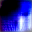

In [ ]:
# Send to ComfyUI Server and Wait for Results
try:
    # 1. Queue Prompt
    response = queue_prompt(workflow)
    print("response:", response)
    prompt_id = response.get('prompt_id')
    print(f"Success! Prompt queued. ID: {prompt_id}")

    # 2. Monitor Loop
    print("Waiting for generation to complete... (this may take a while)")
    while True:
        history = get_history(prompt_id)
        print("history:", history)
        if prompt_id in history:
            print("Generation complete!")
            break
        time.sleep(1)

    # 3. Retrieve and Display Images
    history_data = history[prompt_id]
    outputs = history_data.get('outputs', {})

    if not outputs:
        print("No outputs found in history.")

    for node_id, node_output in outputs.items():
        if 'images' in node_output:
            for image in node_output['images']:
                filename = image['filename']
                subfolder = image['subfolder']
                folder_type = image['type']

                print(f"Downloading and displaying: {filename}")
                image_data = get_image(filename, subfolder, folder_type)
                display(Image(data=image_data))

except urllib.error.URLError as e:
    print(f"Connection Error: {e}")
    print("Make sure the ComfyUI server is running at", COMFYUI_SERVER_ADDRESS)
except Exception as e:
    print(f"An error occurred: {e}")